In [119]:
import requests
import pandas as pd
import numpy as np

In [120]:
import requests
import pandas as pd

def fetch_nasa_hourly_data(latitude, longitude, start_year, end_year):
    """Fetch hourly solar and weather data from NASA POWER API for multiple parameters and merge them year by year."""
    
    parameters = ["ALLSKY_SFC_SW_DWN", "T2M", "WS2M", "RH2M", "PRECTOTCORR",'CLOUD_AMT' ]
    base_url = "https://power.larc.nasa.gov/api/temporal/hourly/point"
    
    df_final = None  # Initialize final DataFrame

    # Loop through years to fetch data in smaller chunks
    for year in range(start_year, end_year + 1):
        dfs = []  # Store DataFrames for each parameter

        for param in parameters:
            url = f"{base_url}?parameters={param}&community=RE&longitude={longitude}&latitude={latitude}&start={year}0101&end={year}1231&format=JSON"
            response = requests.get(url)
            response.raise_for_status()  # Check for errors
            
            data = response.json()
            param_data = data['properties']['parameter'].get(param, {})

            # Convert to DataFrame
            df = pd.DataFrame(list(param_data.items()), columns=['timestamp', param])
            df['timestamp'] = pd.to_datetime(df['timestamp'], format="%Y%m%d%H")
            dfs.append(df)

        # Merge all parameters for the given year
        df_year = dfs[0]
        for df in dfs[1:]:
            df_year = df_year.merge(df, on='timestamp', how='outer')

        # Append to final DataFrame
        df_final = df_year if df_final is None else pd.concat([df_final, df_year])

    # Sort by timestamp
    df_final = df_final.sort_values('timestamp').reset_index(drop=True)

    # Extract year, month, day, hour for filtering
    df_final['year'] = df_final['timestamp'].dt.year
    df_final['month'] = df_final['timestamp'].dt.month
    df_final['day'] = df_final['timestamp'].dt.day
    df_final['hour'] = df_final['timestamp'].dt.hour

    return df_final

# Example usage
latitude, longitude = 37.7749, -122.4194  # San Francisco coordinates
df_hourly = fetch_nasa_hourly_data(latitude, longitude, start_year=2010,end_year=2021)

# Display first few rows
print(df_hourly.head())


            timestamp  ALLSKY_SFC_SW_DWN    T2M  WS2M   RH2M  PRECTOTCORR  \
0 2010-01-01 00:00:00                0.0  10.14  1.93  91.97         0.43   
1 2010-01-01 01:00:00                0.0  10.24  1.94  91.59         0.61   
2 2010-01-01 02:00:00                0.0  10.27  1.92  91.26         0.78   
3 2010-01-01 03:00:00                0.0  10.25  1.90  91.21         0.84   
4 2010-01-01 04:00:00                0.0  10.06  1.83  92.21         1.54   

   CLOUD_AMT  year  month  day  hour  
0      100.0  2010      1    1     0  
1      100.0  2010      1    1     1  
2      100.0  2010      1    1     2  
3      100.0  2010      1    1     3  
4      100.0  2010      1    1     4  


In [121]:
#apply time series regression. 
#convert the features into meaning full data line hours need to be converted into sine/cosine so that the model understands the differnece between hours

# for hourly variation
df_hourly['hour_sin']=np.sin(2*np.pi*df_hourly['hour']/24)
df_hourly['hour_cos']=np.cos(2*np.pi*df_hourly['hour']/24)

#for daily variation
#convert day of the year to sine cosine to capture 
df_hourly['day_of_year_sin']= np.sin(2*np.pi*df_hourly['day']/365)
df_hourly['day_of_year_cos']= np.sin(2*np.pi*df_hourly['day']/365)

# since linear regression dosent capture the past data effectively its important to introduce lag features into the model 

df_hourly['lag1']= df_hourly['ALLSKY_SFC_SW_DWN'].shift(1)
df_hourly['lag24']= df_hourly['ALLSKY_SFC_SW_DWN'].shift(24)
df_hourly['lag365']= df_hourly['ALLSKY_SFC_SW_DWN'].shift(8760)

df_hourly.dropna(inplace=True)

df_hourly.drop(['year','month','day','hour','timestamp'],inplace=True, axis=1)

df_hourly

,ALLSKY_SFC_SW_DWN,T2M,WS2M,RH2M,PRECTOTCORR,CLOUD_AMT,hour_sin,hour_cos,day_of_year_sin,day_of_year_cos,lag1,lag24,lag365
8760,0.0,6.36,3.36,97.02,16.26,100.00,0.000000,1.000000,0.017213,0.017213,0.0,0.0,0.0
8761,0.0,6.46,3.42,97.15,17.10,100.00,0.258819,0.965926,0.017213,0.017213,0.0,0.0,0.0
8762,0.0,6.66,3.27,96.95,16.63,94.83,0.500000,0.866025,0.017213,0.017213,0.0,0.0,0.0
8763,0.0,7.05,2.79,97.10,14.99,100.00,0.707107,0.707107,0.017213,0.017213,0.0,0.0,0.0
8764,0.0,7.34,2.06,97.57,18.91,99.27,0.866025,0.500000,0.017213,0.017213,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105187,0.0,6.44,2.95,93.93,0.00,9.97,-0.965926,0.258819,0.508671,0.508671,0.0,0.0,0.0
105188,0.0,5.89,2.87,96.94,0.00,8.13,-0.866025,0.500000,0.508671,0.508671,0.0,0.0,0.0
105189,0.0,5.38,2.82,98.87,0.00,6.28,-0.707107,0.707107,0.508671,0.508671,0.0,0.0,0.0
105190,0.0,5.03,2.77,98.99,0.00,4.45,-0.500000,0.866025,0.508671,0.508671,0.0,0.0,0.0


<Axes: >

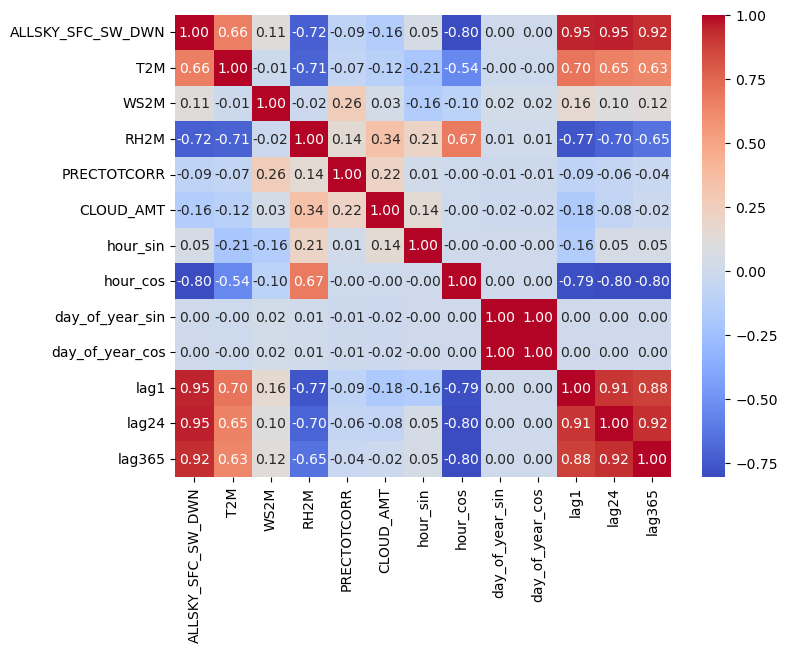

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix=df_hourly.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)


In [123]:
# standardize the continuous variables like T2M, WS2M, RH2M, PRECTOTCORR, CLOUD_AMT
from sklearn.preprocessing import StandardScaler
scalar=StandardScaler()
col_to_scale=['T2M', 'WS2M', 'RH2M','PRECTOTCORR', 'CLOUD_AMT']
df_hourly[col_to_scale]=scalar.fit_transform(df_hourly[col_to_scale])
df_hourly

,ALLSKY_SFC_SW_DWN,T2M,WS2M,RH2M,PRECTOTCORR,CLOUD_AMT,hour_sin,hour_cos,day_of_year_sin,day_of_year_cos,lag1,lag24,lag365
8760,0.0,-1.516432,1.108187,1.053128,1.891424,1.333689,0.000000,1.000000,0.017213,0.017213,0.0,0.0,0.0
8761,0.0,-1.496281,1.169174,1.059686,1.998673,1.333689,0.258819,0.965926,0.017213,0.017213,0.0,0.0,0.0
8762,0.0,-1.455980,1.016706,1.049597,1.938664,1.188204,0.500000,0.866025,0.017213,0.017213,0.0,0.0,0.0
8763,0.0,-1.377394,0.528809,1.057164,1.729274,1.333689,0.707107,0.707107,0.017213,0.017213,0.0,0.0,0.0
8764,0.0,-1.318958,-0.213202,1.080874,2.229769,1.313146,0.866025,0.500000,0.017213,0.017213,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105187,0.0,-1.500311,0.691441,0.897249,-0.184608,-1.199765,-0.965926,0.258819,0.508671,0.508671,0.0,0.0,0.0
105188,0.0,-1.611139,0.610125,1.049093,-0.184608,-1.251543,-0.866025,0.500000,0.508671,0.508671,0.0,0.0,0.0
105189,0.0,-1.713906,0.559302,1.146454,-0.184608,-1.303602,-0.707107,0.707107,0.508671,0.508671,0.0,0.0,0.0
105190,0.0,-1.784432,0.508480,1.152507,-0.184608,-1.355098,-0.500000,0.866025,0.508671,0.508671,0.0,0.0,0.0


In [124]:
Y_train=df_hourly['ALLSKY_SFC_SW_DWN'].to_frame()
df_hourly.drop(['ALLSKY_SFC_SW_DWN'],axis=1, inplace=True)
X_train=df_hourly

In [125]:
X_train

,T2M,WS2M,RH2M,PRECTOTCORR,CLOUD_AMT,hour_sin,hour_cos,day_of_year_sin,day_of_year_cos,lag1,lag24,lag365
8760,-1.516432,1.108187,1.053128,1.891424,1.333689,0.000000,1.000000,0.017213,0.017213,0.0,0.0,0.0
8761,-1.496281,1.169174,1.059686,1.998673,1.333689,0.258819,0.965926,0.017213,0.017213,0.0,0.0,0.0
8762,-1.455980,1.016706,1.049597,1.938664,1.188204,0.500000,0.866025,0.017213,0.017213,0.0,0.0,0.0
8763,-1.377394,0.528809,1.057164,1.729274,1.333689,0.707107,0.707107,0.017213,0.017213,0.0,0.0,0.0
8764,-1.318958,-0.213202,1.080874,2.229769,1.313146,0.866025,0.500000,0.017213,0.017213,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
105187,-1.500311,0.691441,0.897249,-0.184608,-1.199765,-0.965926,0.258819,0.508671,0.508671,0.0,0.0,0.0
105188,-1.611139,0.610125,1.049093,-0.184608,-1.251543,-0.866025,0.500000,0.508671,0.508671,0.0,0.0,0.0
105189,-1.713906,0.559302,1.146454,-0.184608,-1.303602,-0.707107,0.707107,0.508671,0.508671,0.0,0.0,0.0
105190,-1.784432,0.508480,1.152507,-0.184608,-1.355098,-0.500000,0.866025,0.508671,0.508671,0.0,0.0,0.0


In [126]:
from sklearn.model_selection import train_test_split

X_train_split,X_test_split,Y_train_split,Y_test_split = train_test_split(X_train,Y_train,test_size=0.2,shuffle=False)

In [127]:
def Regression_report(report,df_ori,df_pred):
    mae=mean_absolute_error(df_ori,df_pred)
    mse = mean_squared_error(df_ori,df_pred)
    rmse = mean_squared_error(df_ori,df_pred, squared=False)
    r2 = r2_score(df_ori,df_pred)
    error= mae/(df_ori.mean())
    cust_metric= (1-(mae/1660))
    print(f"Regression_report{report}\n")
    print(f"\nmae: {mae}\nmse: {mse}\nrmse: {rmse}\nr2: {r2}\n%error: {error} ")
    print(f"Cust_value : {cust_metric}\n")

In [128]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,make_scorer,fbeta_score,confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
linear_reg=LinearRegression()
linear_reg.fit(X_train,Y_train)
Y_lin_pred= linear_reg.predict(X_test_split)
Regression_report('linear_reg_test',Y_test_split,Y_lin_pred)

Regression_reportlinear_reg_test


mae: 38.0042248390375
mse: 2404.1135289916797
rmse: 49.031760410897746
r2: 0.9673300119282243
%error: ALLSKY_SFC_SW_DWN    0.197427
dtype: float64 
Cust_value : 0.9771058886511822



C:\Users\yaswa\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


<Axes: >

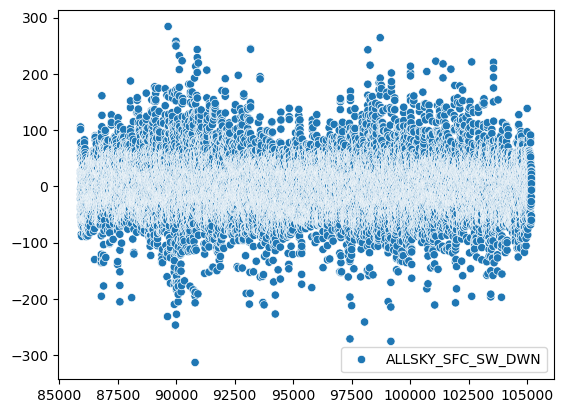

In [129]:
Resi=Y_test_split-Y_lin_pred
sns.scatterplot(Resi)

In [130]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
Param_grid={ 'alpha': [4900,4850] }
linear_regu = Ridge(fit_intercept= True)
cv_grid_search= GridSearchCV(linear_regu,n_jobs=-1,cv=10, scoring='neg_mean_absolute_error',param_grid=Param_grid)
cv_grid_search.fit(X_train_split,Y_train_split)
print('best_parameters',cv_grid_search.best_params_)
best_model=cv_grid_search.best_estimator_
Y_ridge_train_pred=best_model.predict(X_train_split)
Y_ridge_test_pred=best_model.predict(X_test_split)

coefficient=best_model.coef_
Intercept=best_model.intercept_
print(f'coefficient\n{coefficient}\n\n Intercept:{Intercept}')
Regression_report("Train_set",Y_train_split,Y_ridge_train_pred)

Regression_report("Test_set",Y_test_split,Y_ridge_test_pred)

best_parameters {'alpha': 4900}
coefficient
[[ -2.52014305  -3.77485268   0.63963433  -1.32618823 -12.88539727
   38.78665414  -3.3510466   -0.08121512  -0.08121512   0.52239513
    0.31608218   0.17063885]]

 Intercept:[-1.33349305]
Regression_reportTrain_set


mae: 38.409234956471764
mse: 2710.5672179549533
rmse: 52.06310803203122
r2: 0.9645536118483725
%error: ALLSKY_SFC_SW_DWN    0.192947
dtype: float64 
Cust_value : 0.9768619066527279

Regression_reportTest_set


mae: 37.10297671587186
mse: 2405.8842603108683
rmse: 49.04981407009478
r2: 0.9673059490999183
%error: ALLSKY_SFC_SW_DWN    0.192745
dtype: float64 
Cust_value : 0.9776488092073061



C:\Users\yaswa\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\yaswa\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [131]:
Param_grid={ 'alpha': [1.2,1,0.9] }
linear_lasso = Lasso(fit_intercept= True)
cv_grid_search= GridSearchCV(linear_lasso,n_jobs=-1,cv=10, scoring='neg_mean_absolute_error',param_grid=Param_grid)
cv_grid_search.fit(X_train_split,Y_train_split)
print('best_parameters',cv_grid_search.best_params_)
best_model=cv_grid_search.best_estimator_
Y_lasso_train_pred=best_model.predict(X_train_split)
Y_lasso_test_pred=best_model.predict(X_test_split)

coefficient=best_model.coef_
Intercept=best_model.intercept_
print(f'coefficient\n{coefficient}\n\n Intercept:{Intercept}')
Regression_report("Train_set",Y_train_split,Y_lasso_train_pred)

Regression_report("Test_set",Y_test_split,Y_lasso_test_pred)

best_parameters {'alpha': 1.2}
coefficient
[ -0.          -2.38481319  -0.          -0.41542623 -12.39451127
  43.21369517  -0.          -0.          -0.           0.53206786
   0.30877182   0.16767477]

 Intercept:[-1.22973343]
Regression_reportTrain_set


mae: 38.99519643826608
mse: 2704.3697984747237
rmse: 52.0035556330019
r2: 0.964634656190302
%error: ALLSKY_SFC_SW_DWN    0.195891
dtype: float64 
Cust_value : 0.9765089178082734

Regression_reportTest_set


mae: 37.833679164819365
mse: 2419.6973321485125
rmse: 49.19041910929925
r2: 0.967118240455244
%error: ALLSKY_SFC_SW_DWN    0.196541
dtype: float64 
Cust_value : 0.977208627009145



C:\Users\yaswa\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\yaswa\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [132]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for the Decision Tree model
param_grid_dt = {
    'max_depth': [5, 10, 15, None], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Decision Tree Regressor
dt_regressor = DecisionTreeRegressor()

# Perform GridSearchCV
cv_grid_search_dt = GridSearchCV(dt_regressor, param_grid=param_grid_dt, n_jobs=-1, cv=10, scoring='neg_mean_absolute_error')
cv_grid_search_dt.fit(X_train_split, Y_train_split)

# Best parameters and model
print('Best Parameters for Decision Tree:', cv_grid_search_dt.best_params_)
best_model_dt = cv_grid_search_dt.best_estimator_

# Predictions
Y_dt_train_pred = best_model_dt.predict(X_train_split)
Y_dt_test_pred = best_model_dt.predict(X_test_split)

# Model coefficients (for decision trees, it's less intuitive than for linear models)
print(f'Best Decision Tree Model\n{best_model_dt}')

# Evaluate the model
Regression_report("Train_set", Y_train_split, Y_dt_train_pred)
Regression_report("Test_set", Y_test_split, Y_dt_test_pred)

Best Parameters for Decision Tree: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best Decision Tree Model
DecisionTreeRegressor(max_depth=15, min_samples_leaf=4, min_samples_split=10)
Regression_reportTrain_set


mae: 7.221431096757387
mse: 262.99238488882185
rmse: 16.217039954591648
r2: 0.9965608194130213
%error: ALLSKY_SFC_SW_DWN    0.036277
dtype: float64 
Cust_value : 0.9956497403031582

Regression_reportTest_set


mae: 12.422696789449208
mse: 750.609370627879
rmse: 27.397251150943575
r2: 0.9897998164856795
%error: ALLSKY_SFC_SW_DWN    0.064534
dtype: float64 
Cust_value : 0.9925164477171993



C:\Users\yaswa\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\yaswa\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [212]:
Y_dt_pred_df= pd.DataFrame(Y_dt_test_pred, index=Y_test_split.index,columns=['Pred'])
dt_Residuals=pd.concat([Y_test_split,Y_dt_pred_df],axis=1)
# Y_dt_pred_df.index==Y_test_split.index
# Y_dt_pred_df
# Y_test_split
dt_Residuals['ALLSKY_SFC_SW_DWN'] = np.where(dt_Residuals['ALLSKY_SFC_SW_DWN'] == 0, np.nan, dt_Residuals['ALLSKY_SFC_SW_DWN'])

dt_Residuals['diff']=(dt_Residuals['ALLSKY_SFC_SW_DWN']-dt_Residuals['Pred'])/dt_Residuals['ALLSKY_SFC_SW_DWN']
dt_Residuals['diff'].describe()

count    9818.000000
mean       -0.460453
std        32.050617
min     -2856.000000
25%        -0.070070
50%        -0.004816
75%         0.047575
max         1.000000
Name: diff, dtype: float64

In [218]:
#let us check the error in the when simply actuals and 365 lag to see if we were not to use any models and use last years value are we better off?
lag_365=X_train['lag365'].to_frame()
df_val= pd.concat([Y_train,lag_365], axis=1)
df_val['ALLSKY_SFC_SW_DWN'] = np.where(df_val['ALLSKY_SFC_SW_DWN'] == 0, np.nan, df_val['ALLSKY_SFC_SW_DWN'])
df_val['differnce']=(df_val['ALLSKY_SFC_SW_DWN']-df_val['lag365'])/df_val['ALLSKY_SFC_SW_DWN']
# print(Regression_report("Test",df_val['ALLSKY_SFC_SW_DWN'],df_val['lag365']))
df_val['differnce'].describe()

count    49885.000000
mean        -0.727595
std         40.208889
min      -3791.000000
25%         -0.272964
50%          0.001531
75%          0.223523
max          1.000000
Name: differnce, dtype: float64

<Axes: ylabel='differnce'>

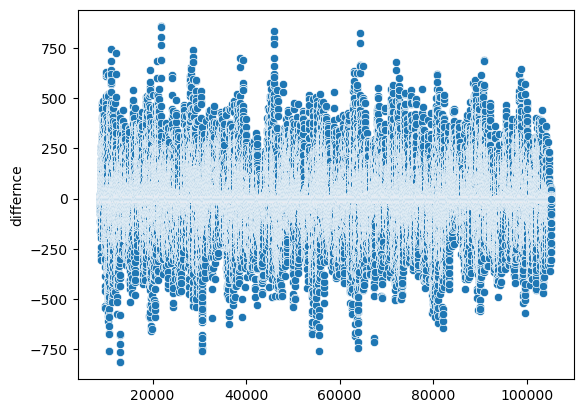

In [134]:
sns.scatterplot(df_val['differnce'])

In [220]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error

# Step 1: Reshape data into 3D arrays (samples, time steps, features)
# Assuming X_train_split and X_test_split are already in a suitable format

# LSTM expects the input data to be of shape (n_samples, time_steps, n_features)
# Reshaping data
X_train_lstm = np.array(X_train_split)
X_test_lstm = np.array(X_test_split)

# If your data is 2D, you can reshape it to 3D by adding an extra dimension
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], 1, X_train_lstm.shape[1]))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], 1, X_test_lstm.shape[1]))

# Step 2: Build the LSTM model
model = Sequential()

# Add LSTM layers
model.add(LSTM(units=50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dense(units=1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

# Step 3: Train the LSTM model
model.fit(X_train_lstm, Y_train_split, epochs=20, batch_size=32, verbose=1)

# Step 4: Make predictions
Y_lstm_train_pred = model.predict(X_train_lstm)
Y_lstm_test_pred = model.predict(X_test_lstm)

# Step 5: Evaluate the model (using MAE or another evaluation metric)
train_mae = mean_absolute_error(Y_train_split, Y_lstm_train_pred)
test_mae = mean_absolute_error(Y_test_split, Y_lstm_test_pred)

print(f'Training MAE: {train_mae}')
print(f'Test MAE: {test_mae}')

# You can also define a custom regression report function as you did with the Decision Tree
Regression_report("Train_set", Y_train_split, Y_lstm_train_pred)
Regression_report("Test_set", Y_test_split, Y_lstm_test_pred)

C:\Users\yaswa\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 48.3017
Epoch 2/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 24.3092
Epoch 3/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 18.4116
Epoch 4/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 16.2555
Epoch 5/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 14.9511
Epoch 6/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 14.6803
Epoch 7/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 14.5987
Epoch 8/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 14.1171
Epoch 9/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 14.1054
Epoch 10/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 13.5673
Epoch 11/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 13.4043
Epoch 12/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 13.7556
Epoch 13/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 12.9632
Epoch 14/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 12.7556
Ep

C:\Users\yaswa\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\yaswa\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
